# Installs

In [1]:
# Install packages
required_packages <- c(
  "gamlss", "forecast", "ggplot2", "dplyr", "tidyr",
  "lubridate", "gamlss.dist", "zoo", "tseries", "splines"
)

for (pkg in required_packages) {
  if (!require(pkg, character.only = TRUE)) {
    install.packages(pkg, dependencies = TRUE)
  }
}

# Load libraries
library(gamlss)
library(forecast)
library(ggplot2)
library(dplyr)
library(tidyr)
library(lubridate)
library(gamlss.dist)
library(zoo)
library(tseries)
library(splines)

Loading required package: gamlss

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘gamlss’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gamlss.data’, ‘gamlss.dist’, ‘distributions3’


Loading required package: forecast

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘forecast’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘x13binary’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’, ‘forecTheta’, ‘rticles’, ‘seasonal’, ‘uroot’


Loading required package: ggplot2

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following obje

# Data Loading

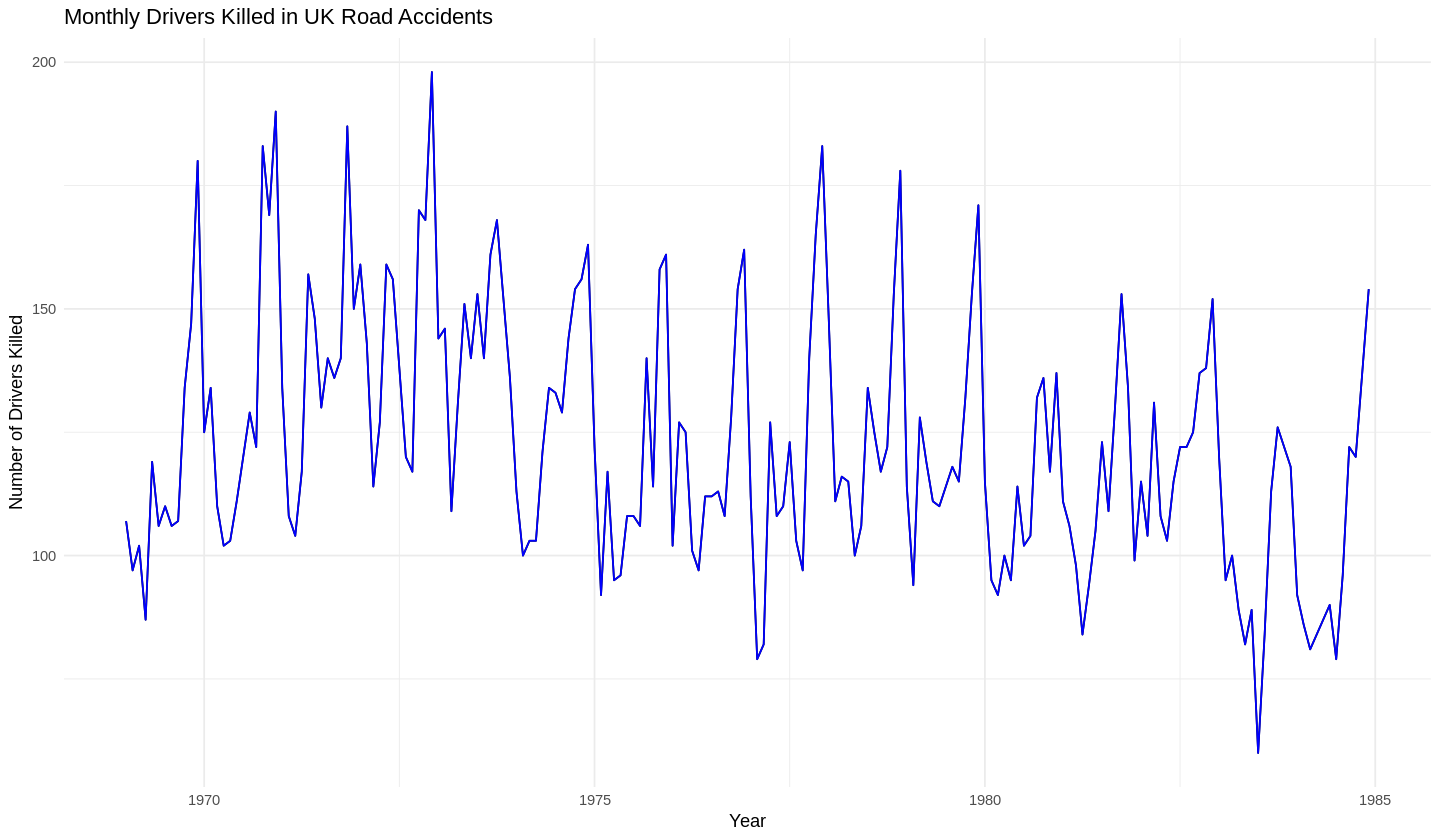

In [2]:
# Load the Seatbelts dataset
data("Seatbelts")

# Extract the "DriversKilled" variable
drivers_killed_ts <- Seatbelts[, "DriversKilled"]

# Plot the time series
options(repr.plot.width=12, repr.plot.height=7)
autoplot(drivers_killed_ts) +
  geom_line(color = "blue") +
  ggtitle("Monthly Drivers Killed in UK Road Accidents") +
  xlab("Year") + ylab("Number of Drivers Killed") +
  theme_minimal()

In [3]:
# Convert the time series to a dataframe
df <- data.frame(
  date = as.Date(as.yearmon(time(drivers_killed_ts))),
  drivers_killed = as.numeric(drivers_killed_ts)
)

head(df)
cat("\n")
tail(df)

,date,drivers_killed
,<date>,<dbl>
1,1969-01-01,107
2,1969-02-01,97
3,1969-03-01,102
4,1969-04-01,87
5,1969-05-01,119
6,1969-06-01,106


,date,drivers_killed
,<date>,<dbl>
187,1984-07-01,79
188,1984-08-01,96
189,1984-09-01,122
190,1984-10-01,120
191,1984-11-01,137
192,1984-12-01,154


In [4]:
# Include exogenous variables
df$PetrolPrice <- as.numeric(Seatbelts[, "PetrolPrice"])
df$kms <- as.numeric(Seatbelts[, "kms"])

head(df)

,date,drivers_killed,PetrolPrice,kms
,<date>,<dbl>,<dbl>,<dbl>
1,1969-01-01,107,0.1029718,9059
2,1969-02-01,97,0.1023630,7685
3,1969-03-01,102,0.1020625,9963
4,1969-04-01,87,0.1008733,10955
5,1969-05-01,119,0.1010197,11823
6,1969-06-01,106,0.1005812,12391


# Data Exploration

In [5]:
# Check for stationarity using Augmented Dickey-Fuller test
adf_test <- adf.test(df$drivers_killed)
print(adf_test)

Warning message in adf.test(df$drivers_killed):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  df$drivers_killed
Dickey-Fuller = -6.1975, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary



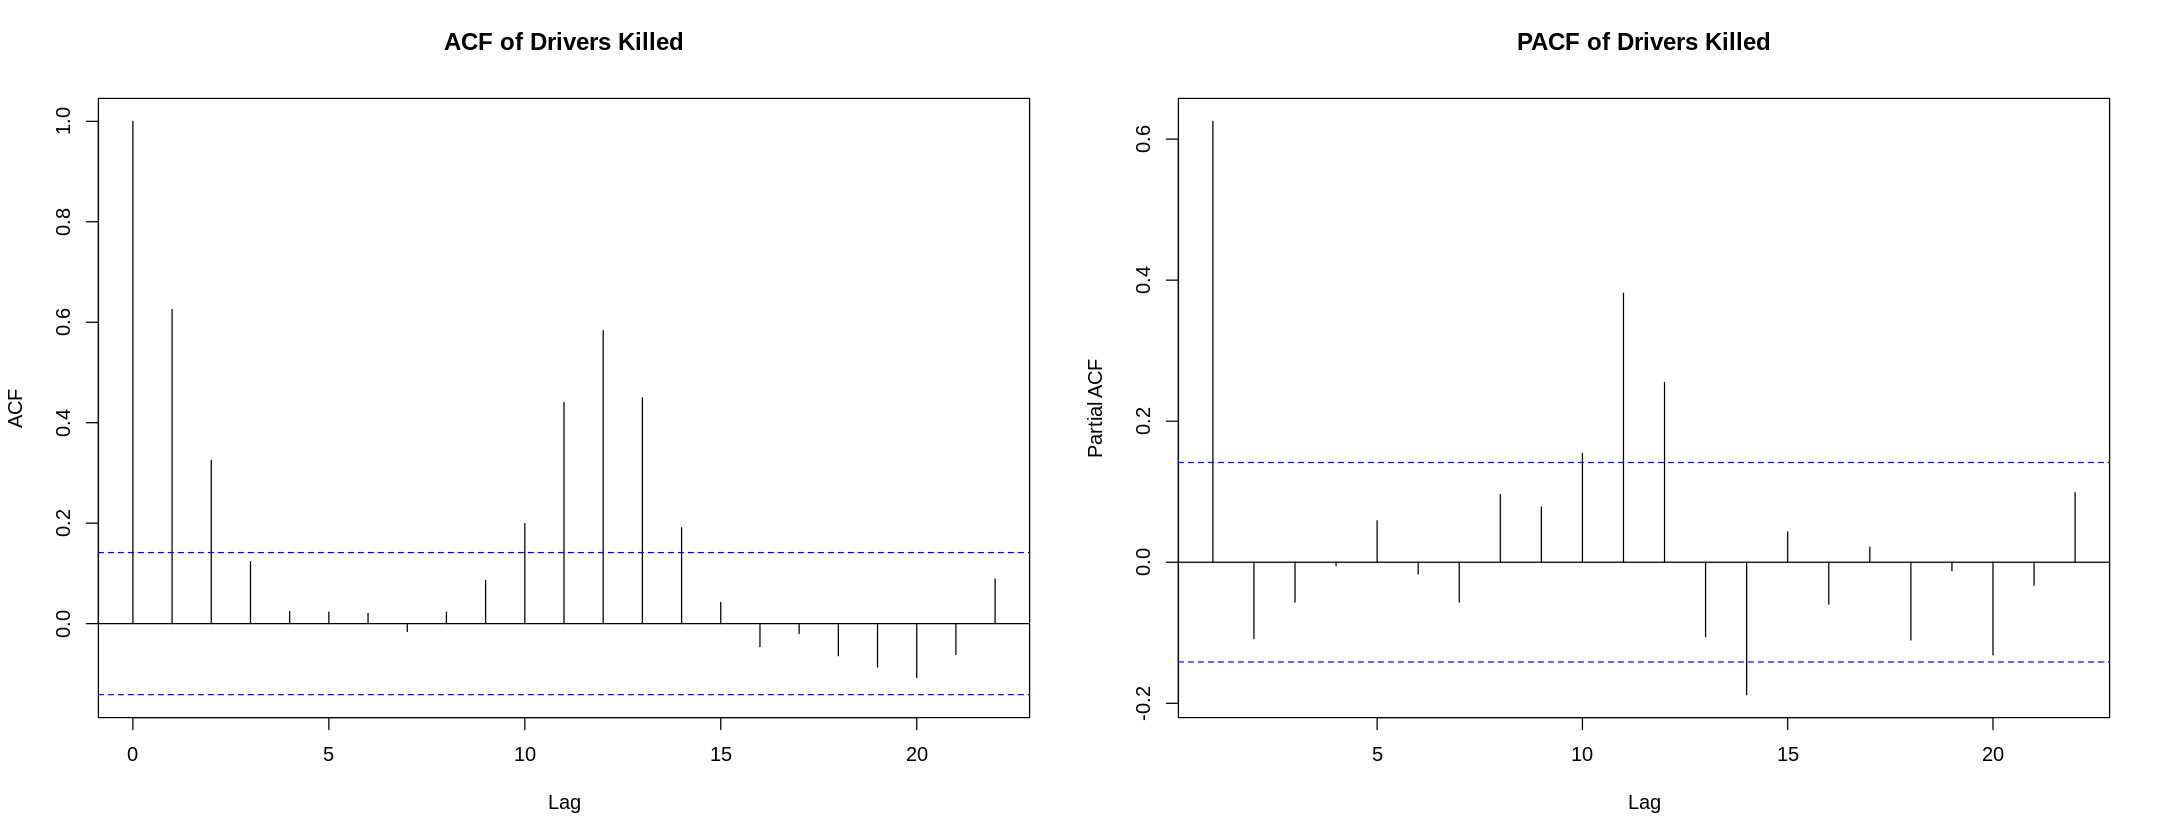

In [6]:
# Plot ACF and PACF
options(repr.plot.width=18, repr.plot.height=7)
par(mfrow = c(1, 2))
acf(df$drivers_killed, main = "ACF of Drivers Killed")
pacf(df$drivers_killed, main = "PACF of Drivers Killed")
par(mfrow = c(1,1))

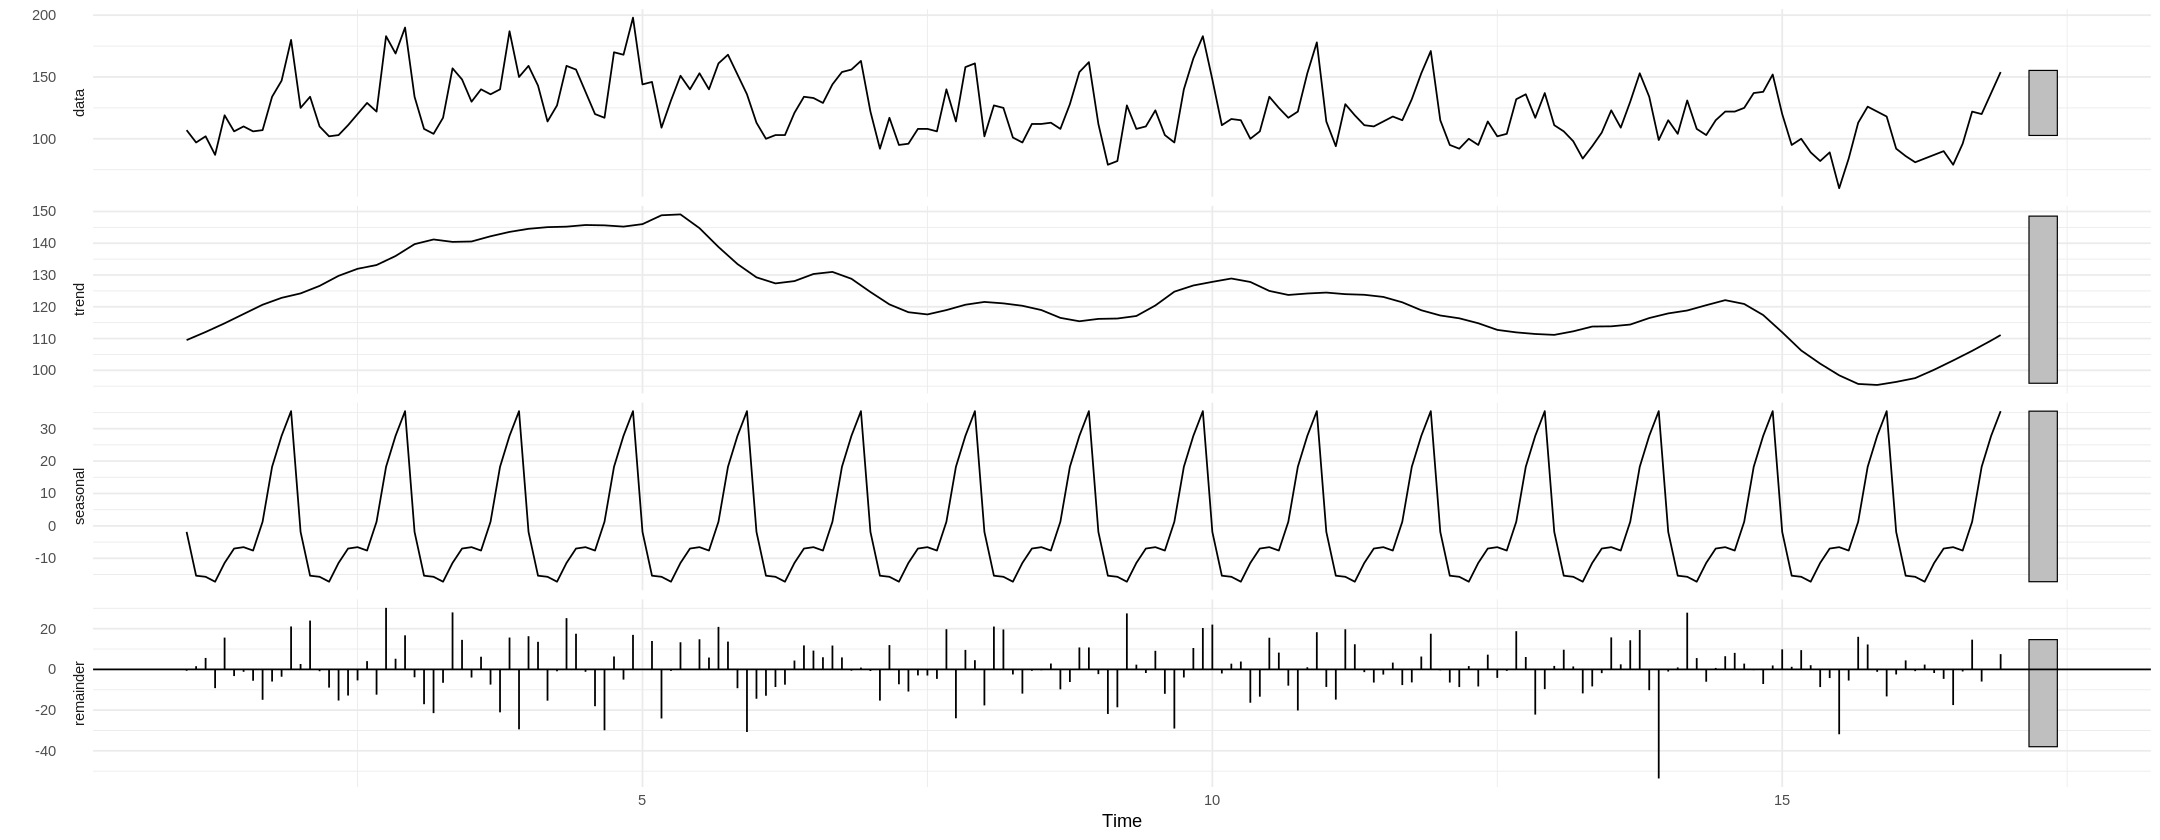

In [7]:
# Decompose the time series to check for seasonality
decomp <- stl(ts(df$drivers_killed, frequency = 12), s.window = "periodic")
autoplot(decomp) + theme_minimal()

# Variable Creation

In [8]:
# Create lag variables for the target variable
lag_steps <- c(1, 3, 6, 12)
for (i in lag_steps) {
  df[[paste0("lag_drivers_killed_", i)]] <- lag(df$drivers_killed, i)
}

# Create lagged exogenous variables
for (i in lag_steps) {
  df[[paste0("lag_PetrolPrice_", i)]] <- lag(df$PetrolPrice, i)
  df[[paste0("lag_kms_", i)]] <- lag(df$kms, i)
}

head(df)

,date,drivers_killed,PetrolPrice,kms,lag_drivers_killed_1,lag_drivers_killed_3,lag_drivers_killed_6,lag_drivers_killed_12,lag_PetrolPrice_1,lag_kms_1,lag_PetrolPrice_3,lag_kms_3,lag_PetrolPrice_6,lag_kms_6,lag_PetrolPrice_12,lag_kms_12
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1969-01-01,107,0.1029718,9059,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1969-02-01,97,0.1023630,7685,107,NA,NA,NA,0.1029718,9059,NA,NA,NA,NA,NA,NA
3,1969-03-01,102,0.1020625,9963,97,NA,NA,NA,0.1023630,7685,NA,NA,NA,NA,NA,NA
4,1969-04-01,87,0.1008733,10955,102,107,NA,NA,0.1020625,9963,0.1029718,9059,NA,NA,NA,NA
5,1969-05-01,119,0.1010197,11823,87,97,NA,NA,0.1008733,10955,0.1023630,7685,NA,NA,NA,NA
6,1969-06-01,106,0.1005812,12391,119,102,NA,NA,0.1010197,11823,0.1020625,9963,NA,NA,NA,NA


In [9]:
# Add trend variable
df$trend <- 1:nrow(df)

# Ensure that 'month' has consistent levels
df$month <- factor(month(df$date, label=TRUE), levels=month.abb)

# Transform trend with a spline basis function
# Add harmonic terms for seasonality
df <- df %>%
  mutate(
    trend_ns = ns(trend, df = 4),
    month_sin = sin(2 * pi * trend / 12),
    month_cos = cos(2 * pi * trend / 12)
  )

# Remove rows with NA due to lagging
df <- df %>% drop_na()

head(df)

,date,drivers_killed,PetrolPrice,kms,lag_drivers_killed_1,lag_drivers_killed_3,lag_drivers_killed_6,lag_drivers_killed_12,lag_PetrolPrice_1,lag_kms_1,⋯,lag_kms_3,lag_PetrolPrice_6,lag_kms_6,lag_PetrolPrice_12,lag_kms_12,trend,month,trend_ns,month_sin,month_cos
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<ord>,"<dbl[,4]>",<dbl>,<dbl>
1,1970-01-01,125,0.10127456,9130,180,134,110,107,0.10199719,9267,⋯,11372,0.1037740,13460,0.1029718,9059,13,Jan,"0.002645284, -0.06237703, 0.1871311, -0.1247541",5.000000e-01,8.660254e-01
2,1970-02-01,134,0.10070398,8933,125,147,106,97,0.10127456,9130,⋯,9834,0.1040764,14055,0.1023630,7685,14,Feb,"0.003363246, -0.06732283, 0.2019685, -0.1346457",8.660254e-01,5.000000e-01
3,1970-03-01,110,0.10013961,11000,134,180,107,102,0.10070398,8933,⋯,9267,0.1037740,12106,0.1020625,9963,15,Mar,"0.004200614, -0.07220808, 0.2166242, -0.1444162",1.000000e+00,1.194340e-15
4,1970-04-01,102,0.09862110,10733,110,125,134,87,0.10013961,11000,⋯,9130,0.1030264,11372,0.1008733,10955,16,Apr,"0.005166571, -0.07702812, 0.2310843, -0.1540562",8.660254e-01,-5.000000e-01
5,1970-05-01,103,0.09834929,12912,102,134,147,119,0.09862110,10733,⋯,8933,0.1027301,9834,0.1010197,11823,17,May,"0.006270304, -0.08177829, 0.2453349, -0.1635566",5.000000e-01,-8.660254e-01
6,1970-06-01,111,0.09808018,12926,103,110,180,106,0.09834929,12912,⋯,11000,0.1019972,9267,0.1005812,12391,18,Jun,"0.007520996, -0.08645394, 0.2593618, -0.1729079",3.673940e-16,-1.000000e+00


# Data Splitting

In [10]:
# Split the data into training (80%) and testing (20%) sets
split_index <- floor(0.8 * nrow(df))
train_data <- df[1:split_index, ]
test_data <- df[(split_index + 1):nrow(df), ]

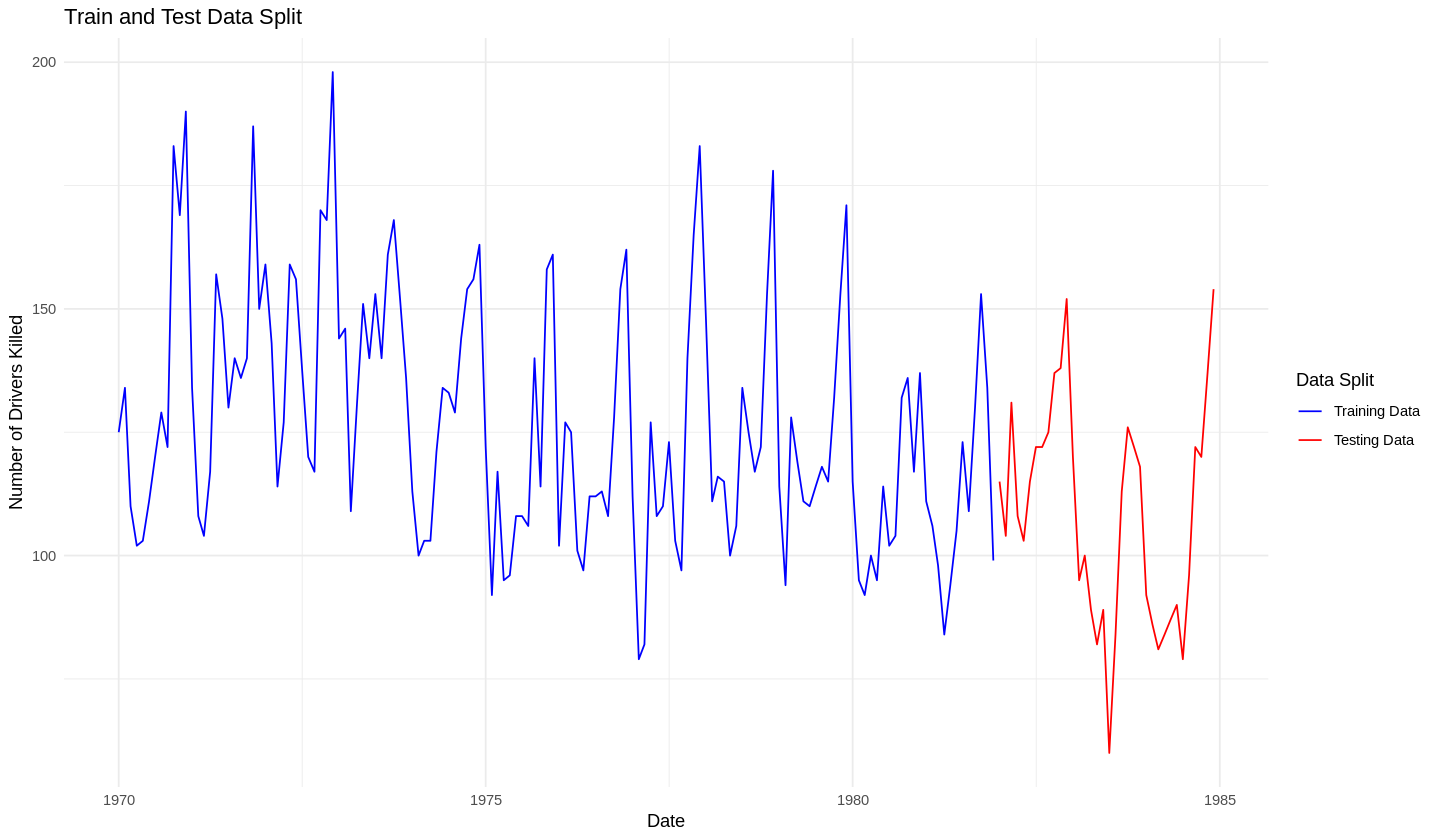

In [11]:
# Visualize the training and testing splits
options(repr.plot.width=12, repr.plot.height=7)
ggplot() +
  geom_line(data = train_data, aes(x = date, y = drivers_killed, color = "Training Data")) +
  geom_line(data = test_data, aes(x = date, y = drivers_killed, color = "Testing Data")) +
  ggtitle("Train and Test Data Split") +
  xlab("Date") + ylab("Number of Drivers Killed") +
  scale_color_manual(
    name = "Data Split",
    values = c("Testing Data" = "red", "Training Data" = "blue")
  ) +
  theme_minimal() +
  guides(color = guide_legend(reverse=TRUE))

# Model Fitting

In [12]:
# Check for overdispersion in count data
mean_count <- mean(train_data$drivers_killed)
var_count <- var(train_data$drivers_killed)
cat("Mean:", mean_count, "\n")
cat("Variance:", var_count, "\n")

Mean: 126.9306 
Variance: 615.114 


In [13]:
# Use Negative Binomial if overdispersion is present
if (var_count > mean_count) {
  family_dist <- NBI()
  cat("Using Negative Binomial distribution.\n")
} else {
  family_dist <- PO()
  cat("Using Poisson distribution.\n")
}

Using Negative Binomial distribution.


In [14]:
# Define the formula for the GAMLSS model
lag_vars <- paste0("lag_drivers_killed_", lag_steps)
lag_exog_vars <- c(paste0("lag_PetrolPrice_", lag_steps), paste0("lag_kms_", lag_steps))
all_predictors <- c("trend_ns", "month_sin", "month_cos", lag_vars, lag_exog_vars)
formula_mu <- as.formula(paste("drivers_killed ~", paste(all_predictors, collapse = " + ")))

In [15]:
# Fit the GAMLSS model on the training data
gamlss_model <- gamlss(
  formula = formula_mu,
  family = family_dist,
  data = train_data,
  control = gamlss.control(n.cyc = 100)
)

# Model summary
summary(gamlss_model)

GAMLSS-RS iteration 1: Global Deviance = 1189.431 
GAMLSS-RS iteration 2: Global Deviance = 1189.371 
GAMLSS-RS iteration 3: Global Deviance = 1189.371 
******************************************************************
Family:  c("NBI", "Negative Binomial type I") 

Call:  gamlss(formula = formula_mu, family = family_dist,  
    data = train_data, control = gamlss.control(n.cyc = 100)) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  log
Mu Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            5.385e+00  5.986e-01   8.997 3.32e-15 ***
trend_ns1              7.357e-02  1.936e-01   0.380   0.7045    
trend_ns2              1.584e-01  2.729e-01   0.580   0.5627    
trend_ns3              5.168e-01  6.164e-01   0.838   0.4034    
trend_ns4              1.647e-01  5.513e-01   0.299   0.7656    
month_sin             -4.459e-02  6.634e-02  -0.672   0.5027    
month_cos              

In [16]:
# Print the model
print(gamlss_model)


Family:  c("NBI", "Negative Binomial type I") 
Fitting method: RS() 

Call:  gamlss(formula = formula_mu, family = family_dist,  
    data = train_data, control = gamlss.control(n.cyc = 100)) 

Mu Coefficients:
          (Intercept)              trend_ns1              trend_ns2  
            5.385e+00              7.357e-02              1.584e-01  
            trend_ns3              trend_ns4              month_sin  
            5.168e-01              1.647e-01             -4.459e-02  
            month_cos   lag_drivers_killed_1   lag_drivers_killed_3  
            1.070e-01              1.056e-03             -1.344e-03  
 lag_drivers_killed_6  lag_drivers_killed_12      lag_PetrolPrice_1  
            2.412e-04              1.777e-03             -3.812e+00  
    lag_PetrolPrice_3      lag_PetrolPrice_6     lag_PetrolPrice_12  
            9.323e-01             -8.971e-01              4.059e-01  
            lag_kms_1              lag_kms_3              lag_kms_6  
           -4.079e

# Model Diagnostics

******************************************************************
	 Summary of the Randomised Quantile Residuals
                           mean   =  -0.0006186497 
                       variance   =  0.9918109 
               coef. of skewness  =  -0.04418214 
               coef. of kurtosis  =  2.315505 
Filliben correlation coefficient  =  0.9951063 
******************************************************************


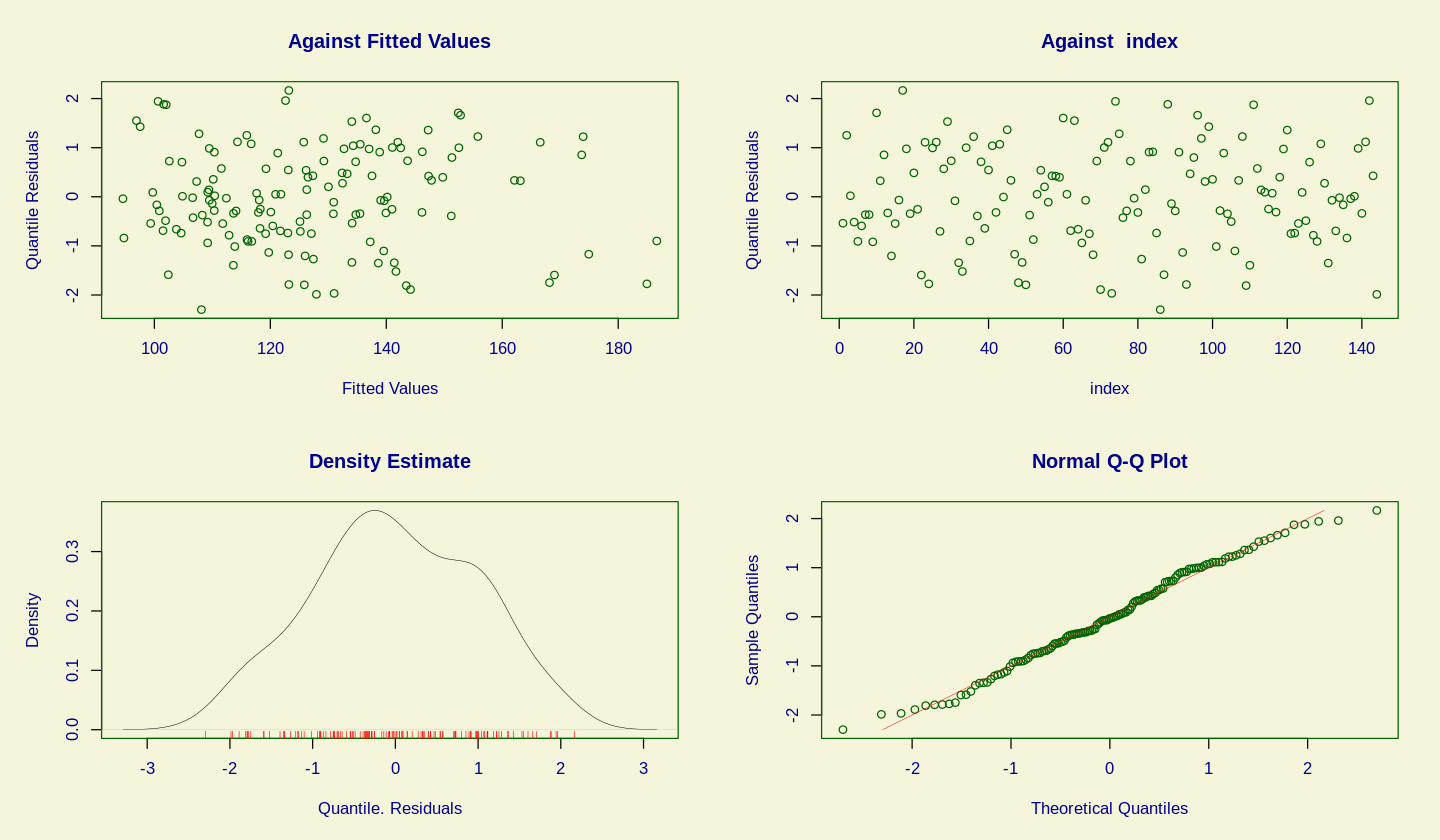

In [17]:
# Evaluate diagnostic plots
options(repr.plot.width=12, repr.plot.height=7)
par(mfrow = c(2,2))
plot(gamlss_model)
par(mfrow = c(1,1))

In [18]:
# Evaluate information criteria metrics
aic <- AIC(gamlss_model)
bic <- GAIC(gamlss_model, k = log(nrow(train_data)))  # BIC = GAIC with k = log(n))

# Calculate Pseudo R-squared
Rsq_values <- Rsq(gamlss_model, type = "both")

# Extract the R-squared values
Rsq_CoxSnell <- Rsq_values$CoxSnell
Rsq_CraggUhler <- Rsq_values$CraggUhler

# Create a dataframe with the metrics
metrics_df <- data.frame(
  Metric = c("AIC", "BIC", "Rsq_CoxSnell", "Rsq_CraggUhler"),
  Value = c(aic, bic, Rsq_CoxSnell, Rsq_CraggUhler)
)

# Print the dataframe
metrics_df

Metric,Value
<chr>,<dbl>
AIC,1229.3708078
BIC,1288.7670738
Rsq_CoxSnell,0.6079933
Rsq_CraggUhler,0.6080550


# Model Predictions

In [19]:
# Obtain mean response predictions
predictions_mean <- predict(
  gamlss_model,
  newdata = test_data,
  type = "response",
  what = "mu"
)

In [20]:
# Obtain sigma predictions
predictions_sigma <- predict(
  gamlss_model,
  newdata = test_data,
  type = "response",
  what = "sigma"
)

In [21]:
# Simulate predictions for prediction intervals
if (!is.null(predictions_sigma)) {
  set.seed(123)
  n_sim <- 1000
  simulated_values <- replicate(n_sim, {
    rNBI(n = nrow(test_data), mu = predictions_mean, sigma = predictions_sigma)
  })

  predictions_lower <- apply(simulated_values, 1, quantile, probs = 0.025)
  predictions_upper <- apply(simulated_values, 1, quantile, probs = 0.975)
} else {
  predictions_lower <- NA
  predictions_upper <- NA
}

In [22]:
# Evaluate predictive metrics
actual <- test_data$drivers_killed
errors <- actual - predictions_mean

MSE <- mean(errors^2)
RMSE <- sqrt(MSE)
MAE <- mean(abs(errors))
MAPE <- mean(abs(errors / actual)) * 100

# Print predictive metrics
cat("MSE:", MSE, "\n")
cat("RMSE:", RMSE, "\n")
cat("MAE:", MAE, "\n")
cat("MAPE(%):", MAPE, "\n")

MSE: 240.7405 
RMSE: 15.51582 
MAE: 12.28625 
MAPE(%): 12.72669 


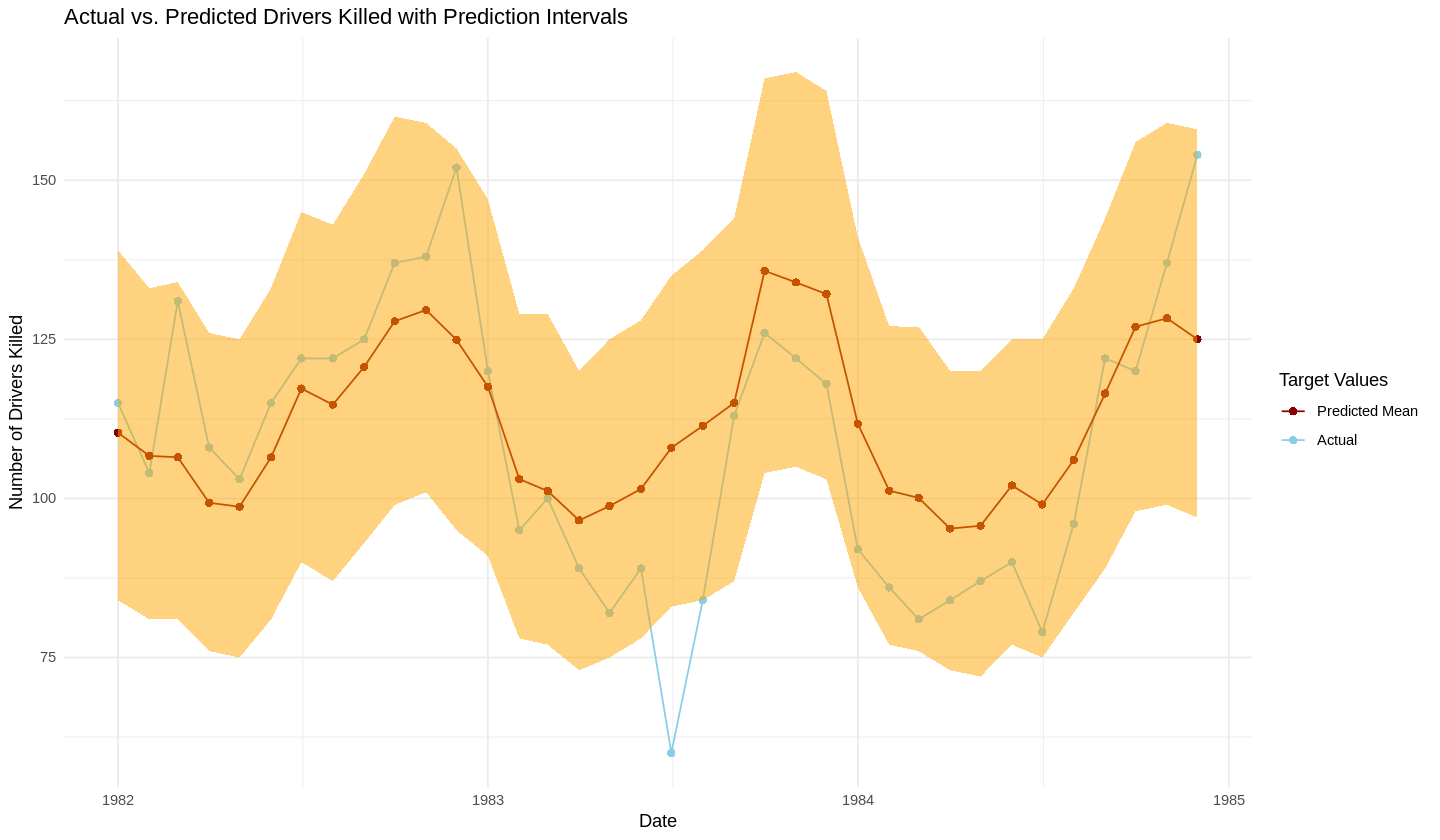

In [24]:
# Plot actual test set values versus predicted values
test_data$predictions_mean <- predictions_mean
test_data$predictions_lower <- predictions_lower
test_data$predictions_upper <- predictions_upper

options(repr.plot.width=12, repr.plot.height=7)
ggplot(test_data, aes(x = date)) +
  # Actual values line and points
  geom_line(aes(y = drivers_killed, color = "Actual")) +
  geom_point(aes(y = drivers_killed, color = "Actual"), shape = 16, size = 2) +

  # Predicted mean line and points
  geom_line(aes(y = predictions_mean, color = "Predicted Mean")) +
  geom_point(aes(y = predictions_mean, color = "Predicted Mean"), shape = 16, size = 2) +

  # Prediction intervals ribbon
  geom_ribbon(aes(ymin = predictions_lower, ymax = predictions_upper), fill = "orange", alpha = 0.5) +

  # Titles and labels
  ggtitle("Actual vs. Predicted Drivers Killed with Prediction Intervals") +
  xlab("Date") + ylab("Number of Drivers Killed") +

  # Manual color scale
  scale_color_manual(
    name = "Target Values",
    values = c("Actual" = "skyblue", "Predicted Mean" = "darkred")
  ) +

  # Minimal theme
  theme_minimal() +

  # Reverse the legend order
  guides(color = guide_legend(reverse = TRUE))